<h1 style="font-size:30px;">Introduction to TFRecord in TensorFlow</h1>

TensorFlow has its own binary data storage format, called TensorFlow Records or TFRecords for short.
The TFRecord format is a simple format for storing a sequence of binary records, which is optimized for high throughput data retrieval and can be used for consuming any data format. Converting your data into TFRecord has many advantages, as documented <a href="https://keras.io/examples/keras_recipes/creating_tfrecords/#introduction" target=_blank>here</a>. In this notebook, we will demonstrate how to use the `TFRecordDataset` class to build a streaming input data pipeline which requires a two-step process: 

1. Transform a dataset into a TFRecord file.
2. Process the TFrecord file to create a streaming data pipeline.

Before we study the code in this notebook, it's helpful to introduce the terminology associated with TFRecords and develop a conceptual picture of the structure. A TFRecord can be seen as a wrapper around all the data examples in a dataset. The data contained in a TFRecord file has a structure that consists of ***Examples*** which are represented as a dictionary. Each ***Example*** contains one or more ***Features*** that contain the data. 

<img src='https://opencv.org/wp-content/uploads/2022/08/c4-04-TFRecord-feature-image.png' align='center' width='700'>

At the coding level, TFRecords use a dictionary to map feature names (keys) to actual (data) values within an *Example*. Each *Feature* in an *Example* has its own data type, and there can be an arbitrary number of *Features* that constitute an *Example*.

TensorFlow provides flexible message types that allow us to create and access TFRecords. `tf.train.Example`  represents a {"string": value} mapping for each *Example* and `tf.train.Feature` is a message type that is used to convert standard TensorFlow types to `tf.train.Example` compatible *Features*. Each data point in an *Example* is first transformed into a *Feature* in a dictionary which is then transformed into an *Example*. The nested structure is represented by the mapping below. 

<img src='https://opencv.org/wp-content/uploads/2022/08/c4-04-example-feature-code.png' align='center' width='600'>

In this notebook, we will learn how to use `tf.train.Example` and `tf.train.Feature` to create TFRecord (`.tfrecord`) files and parse them to create TensorFlow datasets. 

**Notes**: 

- The word "Feature" in this context is an overloaded term and has nothing to do with "image features" that we normally refer to in computer vision.

- The following code examples from the  (<a href="https://www.tensorflow.org/tutorials/load_data/tfrecord" target=_blank>Tensorflow</a>) and (<a href="https://keras.io/examples/keras_recipes/creating_tfrecords/" target=_blank>Keras </a>) documentation pages are both useful references which formed the basis of this notebook.

- Internally, TFRecords use the <a href="https://developers.google.com/protocol-buffers/" target=_blank>Protocol buffers</a> for storing data. Protocol buffers or Protobufs are a language-neutral, platform-neutral format for serializing data. 

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Data](#2-Download-and-Extract-the-Data)
* [3 Training and Dataset Configurations](#3-Training-and-Dataset-Configurations)
* [4 LeNet5 Model](#4-LeNet5-Model)
* [5 TFRecord Building Blocks](#5-TFRecord-Building-Blocks)
* [6 Create Datasets using TFRecords](#5-Create-Datasets-using-TFRecords)
* [7 Compile and Train the Model](#7-Compile-and-Train-the-Model)
* [8 Plot the Training Results](#8-Plot-the-Training-Results)
* [9 Conclusion](#9-Conclusion)

In [ ]:
from tqdm import tqdm
from numpy.random import randn

import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import requests
import zipfile
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import (Conv2D, Activation, Input,
                                     MaxPool2D, Flatten, Dense)

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from tensorflow.keras.utils import to_categorical
from dataclasses import dataclass

AUTOTUNE = tf.data.experimental.AUTOTUNE

block_plot = False

## 1 System Configuration

In [ ]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[]
Using CPU


## 2 Download and Extract the Data

We will use the CIFAR10 dataset just like the previous notebook. Using the same dataset will help to clarify the concepts of different custom data loading techniques. This CIFAR10 dataset has been downloaded from <a href="https://pjreddie.com/projects/cifar-10-dataset-mirror/" target=_blank>Joseph Redmon's website</a> and modified such that all the images are in their respective class folders.

In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
download_file(
    'https://www.dropbox.com/s/6jrhe7uu4a4qxbn/cifar10.zip?dl=1',
    'cifar10.zip'
)
    
unzip(zip_file='cifar10.zip')

Extracted all


```
cifar10
├── labels.txt
├── test
│   ├── airplane
│   ├── automobile
│   ├── bird
│   ├── cat
│   ├── deer
│   ├── dog
│   ├── frog
│   ├── horse
│   ├── ship
│   └── truck
└── train
    ├── airplane
    ├── automobile
    ├── bird
    ├── cat
    ├── deer
    ├── dog
    ├── frog
    ├── horse
    ├── ship
    └── truck
```

As you can see we have `train` and `test` subdirecties which in-turn contain sub-directories for each class in the CIFAR10 dataset. All the class folders contain the respective images.

## 3 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 32
    EPOCHS:        int = 11
    LEARNING_RATE: float= 0.0005
    
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_HEIGHT:  int = 32
    IMG_WIDTH:   int = 32
    DATA_ROOT:   str = './cifar10'

## 4 LeNet5 Model

In [ ]:
def LeNet5_model(num_classes, shape, print_model_summary=True):

    inputs = Input(shape=shape)
    
    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    x = Conv2D(6, 5, padding='valid')(inputs)              # input size = (32, 32), output size = (28, 28)
    x = Activation("relu")(x)                              # output size = (28, 28)
    x = MaxPool2D()(x)                                     # output size = (14, 14)

    # -------------------------------------
    # Second convolutional layer + pooling 
    # -------------------------------------
    x = Conv2D(16, 5, padding='valid')(x)                  # input size = (14, 14), output size = (10, 10)
    x = Activation('relu')(x)                              # output size = (10, 10)
    feature_extractor_output = MaxPool2D()(x)              # output size = (5, 5)

    # Flatten.
    flattened = Flatten()(feature_extractor_output)        # 5 * 5 * 16 -> 400

    # ------------------------- 
    # Fully connected layers.
    # -------------------------
    x = Dense(120, activation='relu')(flattened)           # 400 -> 120
    x = Dense(84, activation='relu')(x)                    # 120 -> 84
    
    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  # 84 -> 10
    
    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')
    
    if print_model_summary:
        model.summary()
        
    return model

In [ ]:
model = LeNet5_model(num_classes=DatasetConfig.NUM_CLASSES,
                     shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                                                            

2022-07-28 09:15:12.461770: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 5 TFRecord Building Blocks

There are several steps required to create and parse TFrecords. In this section, we will walk through a step-by-step process for creating a TFRecord file and parsing it to retrieve the data. Then in the following section, we will process an entire dataset and use it to train a model.

### 5.1 Feature Creation using `tf.train.Feature`

Creating a TFRecord begins at the feature level, where we need to convert standard TensorFlow types to a `tf.train.Example`-compatible `tf.train.Feature`. For this purpose, we use the following convenience functions to convert our data to a `tf.train.Feature` containing one of the following types. In this notebook, we won't need to use the FloatList, but we are listing it here for completeness.

* `BytesList`
* `FloatList`
* `Int64List`

In [ ]:
def _image_feature(value):
    """
    Returns a bytes_list from a string / byte.
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def _bytes_feature(value):
    """
    Returns a bytes_list from a string / byte.
    """
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """
    Returns a float_list from a float / double.
    """
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """
    Returns an int64_list from a bool / enum / int / uint.
    """
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

### 5.2 Example Creation using `tf.train.Example`

Next, we need to define a function that transforms our data into an *Example*. This is where we define the dictionary mapping the feature name to the tf.train.Example-compatible data type. The inputs to this function represent the TensorFlow data that we want to store in a TFRecord file. Notice that these values are converted to `tf.train.Features` using the convenience functions defined above.

In [ ]:
def create_example(image, path_name, label_id, label_name):
    
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible data type.
    feature = {
        'label_id'  : _int64_feature(label_id),
        'label_name': _bytes_feature(tf.compat.as_bytes(label_name)),
        'path_name' : _bytes_feature(tf.compat.as_bytes(path_name)),
        'height'    : _int64_feature(image.shape[0]),
        'width'     : _int64_feature(image.shape[1]),
        'image'     : _image_feature(image)
    }

    # Create a Features message using tf.train.Example.
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    return example

### 5.3 Write a TFRecord File for a Single Example

Before we create an entire dataset to a `TFRecord` file, let's first learn how to convert a single training example to a `TFRecord` file. Here, we define the mapping between label names and label IDs, which will be used further below.

In [ ]:
# Define the `labels` dictionary.
label_names = {
    'airplane'  : 0, 
    'automobile': 1, 
    'bird'      : 2, 
    'cat'       : 3, 
    'deer'      : 4, 
    'dog'       : 5, 
    'frog'      : 6, 
    'horse'     : 7, 
    'ship'      : 8, 
    'truck'     : 9
}

In [ ]:
# Input image file.
image_path = './cifar10/train/airplane/30_airplane.png'

# Output TFRecord file.
record_file = '30_airplane.tfrecords'

with tf.io.TFRecordWriter(record_file) as writer:

    # Read image file from disk.
    image = tf.io.decode_image(tf.io.read_file(image_path))

    # Determine the label name and label ID.
    label_name  = pathlib.Path(image_path).parent.name
    label_id = label_names[label_name]

    # Create example record.
    example = create_example(image, image_path, label_id, label_name)

    # Write example to TFRecord file.
    writer.write(example.SerializeToString())

In [ ]:
%ls -l 30_airplane.tfrecords

-rw-r--r--  1 billk  staff  1449 Jul 28 09:15 30_airplane.tfrecords


### 5.4 Parse TFRecord

Now that we have a `TFRecord` file let's create a function to parse it. This function mirrors the function used to create the *Example* record. It defines a dictionary with the same keys and maps them to fixed-length placeholder features of the same type. The function takes a single input which is serialized *Example* from a TFRecord file, and it uses `tf.io.parse_single_example` to populate a dictionary mapping feature keys to tensor values.

In [ ]:
def parse_tfrecord(example):

    # Dictionary which defines the features.
    feature_description = {
        'label_id'  : tf.io.FixedLenFeature([], tf.int64),
        'label_name': tf.io.FixedLenFeature([], tf.string),
        'path_name' : tf.io.FixedLenFeature([], tf.string),
        'height'    : tf.io.FixedLenFeature([], tf.int64),
        'width'     : tf.io.FixedLenFeature([], tf.int64),
        'image'     : tf.io.FixedLenFeature([], tf.string),
    }

    # Parse the input Example using the dictionary above.
    example = tf.io.parse_single_example(example, feature_description)

    return example

We can now use this function to parse the TFRecord file we created above.  Here, we use `tf.data.TFRecordDataset` to read the TFRecord file and create a dataset in memory. `tf.data.TFRecordDataset` loads TFRecords from the TFRecord file as bytes, exactly as they were written. `TFRecordDataset` does not do any parsing or decoding on its own. Parsing and decoding can be done by applying `Dataset.map` transformations after the `TFRecordDataset`. We then use the `map` method to apply the `parse_tfrecord()` function to the dataset, which parses the *Example*. We can then use the feature keys to extract the data from the dictionary. 

In [ ]:
# Read TFRecord file.
image_dataset = tf.data.TFRecordDataset('30_airplane.tfrecords')

# Parse TFRecord.
parsed_image_dataset = image_dataset.map(parse_tfrecord)

# Retrieve values from dictionary.
for example in parsed_image_dataset.take(1):
    
    label_name   = example['label_name']
    label_id     = example['label_id']
    image_path   = example['path_name']
    image_height = example['height']
    image_width  = example['width']
    
print("label name: ", label_name.numpy())
print("label ID:   ", label_id.numpy())
print("path:       ", image_path.numpy())
print("height:     ", image_height.numpy())
print("width:      ", image_width.numpy())

label name:  b'airplane'
label ID:    0
path:        b'./cifar10/train/airplane/30_airplane.png'
height:      32
width:       32


### 5.5 Decode TFRecord

In the previous section, we demonstrated how to extract feature data directly from the dictionary. However, because some of the data we stored in the TFRecord requires additional processing, we will create another function to decode the image and label data.

In [ ]:
def decode_tfrecord(example):

    image = example['image']
    image = tf.image.decode_image(image, channels=3)

    # Cast to Float32 data type.
    image = tf.cast(image, tf.float32)

    # Normalize the pixels.
    image = image / 255.

    # One-hot encode the labels.
    label_id = example['label_id']
    label_id = tf.one_hot(label_id, DatasetConfig.NUM_CLASSES)

    # Return the decoded image and the label integer.
    return image, label_id

Let's repeat the process for parsing the `TFRecord` using the `decode_tfrecord()` function to decode the image and label ID from the dictionary.

label:     b'airplane'
path:      b'./cifar10/train/airplane/30_airplane.png'
height:    32
width:     32
label_id:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


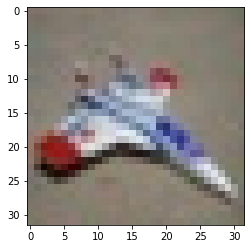

In [ ]:
# Read TFRecord file.
image_dataset = tf.data.TFRecordDataset('30_airplane.tfrecords')

# Parse TFRecord.
parsed_image_dataset = image_dataset.map(parse_tfrecord)

for example in parsed_image_dataset.take(1):
    
    label_name   = example['label_name']
    image_path   = example['path_name']
    image_height = example['height']
    image_width  = example['width']
    
    # Decode image and label_id.
    image, label_id = decode_tfrecord(example)
    
print("label:    ", label_name.numpy())
print("path:     ", image_path.numpy())
print("height:   ", image_height.numpy())
print("width:    ", image_width.numpy())
print("label_id: ", label_id.numpy())

# Display decoded image.
plt.imshow(image);

### 5.6 Combine Parse and Decode Operations

In [ ]:
def parse_and_decode_tfrecord(example):

    # Dictionary which defines the features that we want to parse from the example record.
    feature_description = {
        'label_id'  : tf.io.FixedLenFeature([], tf.int64),
        'image'     : tf.io.FixedLenFeature([], tf.string),
    }

    # Parse the input Example using the dictionary above.
    example = tf.io.parse_single_example(example, feature_description)

    image = example['image']
    image = tf.image.decode_image(image, channels=3)

    # Cast to Float32 data type.
    image = tf.cast(image, tf.float32)

    # Normalize the pixels.
    image = image / 255.

    # One-hot encode the labels.
    label_id = example['label_id']
    label_id = tf.one_hot(label_id, DatasetConfig.NUM_CLASSES)

    # Return the decoded image and the label ID.
    return image, label_id

## 6 Create Datasets using TFRecords

In this section, we'll formalize some of the code above to handle an entire dataset and demonstrate how to create a dataset from a `TFRecord` file that can be used to train a model.

### 6.1 Function to Write TFRecord File

In [ ]:
def write_tf_records(data_path, tfrecord_file_path):
    
    data_dir = pathlib.Path(data_path)

    all_images = list(data_dir.glob('*/*'))
    all_images = [str(path) for path in all_images]
    random.shuffle(all_images)

    image_count = len(all_images)

    # Create TFRecord writer object.
    with tf.io.TFRecordWriter(tfrecord_file_path) as writer:

        # Loop over all filenames.
        for filename in tqdm(all_images):
            
            # Read the image file and decode it.
            image = tf.io.decode_image(tf.io.read_file(filename))
            
            # Parse the label name from the parent folder.
            label_name = pathlib.Path(filename).parent.name

            # Label is the integer mapping of the class name (e.g. 0).
            label_id = label_names[label_name]
            
            # Create Example.
            example = create_example(image, filename, label_id, label_name)

            # Serialize to String and write to a TFRecord file.
            writer.write(example.SerializeToString())

### 6.2 Create TFRecord Files for CIFAR10 Train and Test

In [ ]:
# prepare train record
write_tf_records('./cifar10/train', 'cifar10_train.tfrecords')

# prepare test record
write_tf_records('./cifar10/test', 'cifar10_test.tfrecords')

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1630.55it/s]


### 6.3 Function to Create Train and Test Datasets from TFRecord Files

In [ ]:
def get_dataset(tfrecord_file_path='./cifar10_train.tfrecords'):

    # Read TFRecord file into memory.
    dataset = tf.data.TFRecordDataset(tfrecord_file_path, num_parallel_reads=AUTOTUNE)
    
    # Apply the mapping function to parse and decode the records.
    dataset = dataset.map(parse_and_decode_tfrecord, num_parallel_calls=AUTOTUNE)

    # Set the batch size.
    dataset = dataset.batch(TrainingConfig.BATCH_SIZE)
    
    # Call prefetch to improve throughput.
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

### 6.4 Create Train and Test Datsets

In [ ]:
# Get the training dataset.
train_ds = get_dataset(tfrecord_file_path='./cifar10_train.tfrecords')

# Get the test dataset.
valid_ds = get_dataset(tfrecord_file_path='./cifar10_test.tfrecords')

### 6.5 Display a Few Images from the Datset

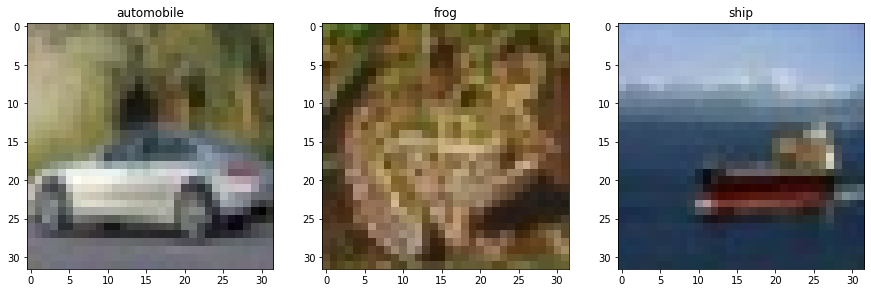

In [ ]:
plt.figure(figsize=(15, 5))

for i, (image_batch, label_batch) in enumerate(train_ds):
    
    if i == 3:
        # Break after three batches.
        break

    # Display the first image from each batch.
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.array(image_batch[0]))
    plt.title(list(label_names.keys())[np.argmax(label_batch[0])]);

## 7 Compile and Train the Model

Here, we will compile and train the model just to confirm that the datasets we generated are valid.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(TrainingConfig.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
             )

history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS,
                    validation_data=valid_ds,
                   )

Epoch 1/11
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6818 - accuracy: 0.3865 - val_loss: 1.4624 - val_accuracy: 0.4692
Epoch 2/11
1563/1563 [==============================] - 15s 10ms/step - loss: 1.4028 - accuracy: 0.4954 - val_loss: 1.3397 - val_accuracy: 0.5188
Epoch 3/11
1563/1563 [==============================] - 15s 9ms/step - loss: 1.2920 - accuracy: 0.5394 - val_loss: 1.2829 - val_accuracy: 0.5404
Epoch 4/11
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2105 - accuracy: 0.5700 - val_loss: 1.2286 - val_accuracy: 0.5663
Epoch 5/11
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1451 - accuracy: 0.5952 - val_loss: 1.1973 - val_accuracy: 0.5799
Epoch 6/11
1563/1563 [==============================] - 17s 11ms/step - loss: 1.0911 - accuracy: 0.6160 - val_loss: 1.1818 - val_accuracy: 0.5885
Epoch 7/11
1563/1563 [==============================] - 18s 12ms/step - loss: 1.0440 - accuracy: 0.6330 - val_loss: 1.1631 - 

## 8 Plot the Training Results

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

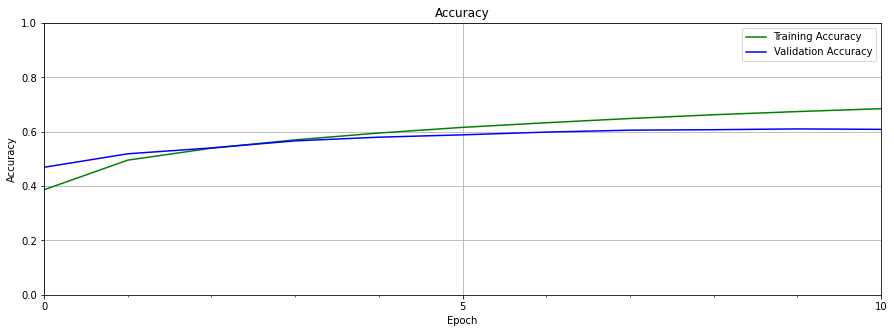

In [ ]:
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

## 9 Conclusion

In this notebook, we demonstrated how to create `TFRecord` files and parse them to create TensorFlow datasets. TensorFlow provides the necessary infrastructure and methods to easily create custom data storage in the form of `TFRecord` files. This approach has numerous benefits for deep learning systems, which include ease of use, flexibility to support a wide range of data types, efficient storage, and fast access. While TensorFlow provides many different approaches for loading and working with data for deep learning systems, TFRecords represents the most robust and efficient method available.  